# Imports

In [25]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk import download
download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Ahmed Mustafa
[nltk_data]     Malik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Defining Tweet Class

In [26]:
class Tweet:
    def __init__(self):
        self.uid = None
        self.content = ''
        self.sentiment = ''

# Definining Methods for Data Loading and Cleaning

In [27]:
def cleanTweet(tweet):
    # print(tweet.content,"\n")
    tweet.content = re.sub(r'\_', '', tweet.content) # remove underscores
    tweet.content = re.sub(r'…', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'\.', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub("@ [a-zA-Z0-9]+", '', tweet.content) # remove @mentions
    tweet.content = re.sub(r'^RT[\s]+', '', tweet.content) # remove RT
    tweet.content = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet.content) # remove hyperlinks
    tweet.content = re.sub(r'#', '', tweet.content) # remove hastags
    tweet.content = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True).tokenize(tweet.content)
    tweet.content = ' '.join([word for word in tweet.content if word not in string.punctuation]) # remove punctuations
    # print(tweet.content)
    # print("============================================================================")
    return tweet

def load_stop_words():
    stopwords_english = stopwords.words('english')
    stopwords_hinglish = []
    with open('data/hinglish_stopwords.txt','r') as fp:
        while True:
            line = fp.readline()
            if not line:
                break
            stopwords_hinglish.append(line.strip())
    return stopwords_english, stopwords_hinglish

def readFile(filename, test_data=False):
    stemmer_english = PorterStemmer()
    stopwords_english, stopwords_hinglish = load_stop_words()
    all_tweets = []
    with open(filename, 'r', encoding="utf8") as fp:
        tweet = Tweet()
        skip = False
        while True:
            line = fp.readline()
            if not line:
                break
            if len(line.split()) > 1:
                if line.split()[0] == 'meta':
                    skip = False
                    if len(tweet.content) > 0:
                        all_tweets.append(cleanTweet(tweet))
                        tweet = Tweet()
                    tweet.uid = line.split()[1]
                    tweet.sentiment = line.split()[2] if test_data==False else None
                elif line.split()[0] == 'http' or line.split()[0] == 'https':
                    skip = True
                elif skip == False:
                    if line.split()[1] == "Eng":
                        if line.split()[0] not in stopwords_english:
                            tweet.content += stemmer_english.stem(line.split()[0]) + " "
                    elif line.split()[1] == "Hin":
                        if line.split()[0] not in stopwords_hinglish:
                            tweet.content += line.split()[0] + " "
                    else:
                        tweet.content += line.split()[0] + " "
        return all_tweets

# Defining Methods for creating Embeddings

## Frequency Based Method

In [28]:
def frequency_based_embeddings(all_tweets):
    freqs = dict()
    for i in all_tweets:
        for word in i.content.split():
            pair = (word, i.sentiment)
            freqs[pair] = freqs.get(pair, 0) + 1
    all_positive_tweets = [i.content for i in all_tweets if i.sentiment=='positive']
    all_negative_tweets = [i.content for i in all_tweets if i.sentiment=='negative']
    all_neutral_tweets = [i.content for i in all_tweets if i.sentiment=='neutral']
    tweets = all_neutral_tweets + all_positive_tweets + all_negative_tweets
    X = np.empty((0,4))
    for i in tweets:
        neutral_words_freq = 0
        positive_words_freq = 0
        negative_words_freq = 0
        for word in i.split():
            neutral_words_freq += freqs.get((word,'neutral'),0)
            positive_words_freq += freqs.get((word,'positive'),0)
            negative_words_freq += freqs.get((word,'negative'),0)
        X = np.append(X, np.array([[1, neutral_words_freq, positive_words_freq, negative_words_freq]]), axis=0)
    Y = np.append(np.zeros(len(all_neutral_tweets)), np.ones(len(all_positive_tweets)))
    Y = np.append(Y, np.full(len(all_negative_tweets),2))
    return X,Y

# Defining Method for Confusion Matrix

In [29]:
def plot_confusion_matrix(cm,title='Confusion Matrix',cmap=plt.cm.Greens):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    classes = ['1','2','3']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def show_results(y_test, y_pred):
    print("F1 Score: ", f1_score(y_test, y_pred, average="macro"))
    print()
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    plot_confusion_matrix(cnf_matrix)

# Mission Control - Training

### Data Loading

In [31]:
# all_tweets = readFile(r'data\train\train_14k_split_conll.txt')
# all_tweets.extend(readFile(r'data\train\dev_3k_split_conll.txt'))
all_tweets = (readFile(r'data\train\train_conll.txt'))
# all_tweets.extend(readFile(r'data\train\trial_conll.txt'))

### Data Analysis

In [32]:
freqs = dict()
for i in [i for i in all_tweets if i.sentiment=='neutral']:
    for word in i.content.split():
        pair = (word, i.sentiment)
        freqs[pair] = freqs.get(pair, 0) + 1
top_10 = list(sorted(freqs.items(), key=lambda x: x[1],reverse=True))[:5]
print("Neutral:")
for i in top_10:
    print(i)
print()

Neutral:
(('😂', 'neutral'), 601)
(('ji', 'neutral'), 509)
(('i', 'neutral'), 491)
(('h', 'neutral'), 409)
(('sir', 'neutral'), 326)



In [33]:
freqs = dict()
for i in [i for i in all_tweets if i.sentiment=='positive']:
    for word in i.content.split():
        pair = (word, i.sentiment)
        freqs[pair] = freqs.get(pair, 0) + 1
top_10 = list(sorted(freqs.items(), key=lambda x: x[1],reverse=True))[:5]
print("Positive")
for i in top_10:
    print(i)
print()

Positive
(('ji', 'positive'), 832)
(('i', 'positive'), 686)
(('love', 'positive'), 618)
(('sir', 'positive'), 506)
(('modi', 'positive'), 482)



In [34]:
freqs = dict()
for i in [i for i in all_tweets if i.sentiment=='negative']:
    for word in i.content.split():
        pair = (word, i.sentiment)
        freqs[pair] = freqs.get(pair, 0) + 1
top_10 = list(sorted(freqs.items(), key=lambda x: x[1],reverse=True))[:5]
print("Negative")
for i in top_10:
    print(i)

Negative
(('h', 'negative'), 471)
(('😂', 'negative'), 463)
(('bjp', 'negative'), 345)
(('ye', 'negative'), 300)
(('modi', 'negative'), 268)


### Creating Embeddings

In [35]:
X,Y = frequency_based_embeddings(all_tweets)

### Data Splitting

In [36]:
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2)

### Model - Training

In [37]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

### The Results

F1 Score:  0.5971637692824195



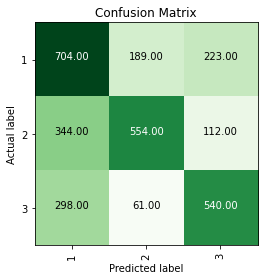

In [38]:
show_results(y_test, y_pred)

# Mission Control - Prediction

### Loading Prediction Data

In [39]:
actual_labels_dict = dict()
with open(r'data\test\test_labels_hinglish.txt','r') as fp:
    line = fp.readline()
    while True:
        line = fp.readline()
        if not line:
            break
        actual_labels_dict[line.strip().split(',')[0]] = line.strip().split(',')[1]
test_data = readFile(r'data\test\Hindi_test_unalbelled_conll_updated.txt',test_data=True)
for i in test_data:
    i.sentiment = actual_labels_dict[i.uid]

### Creating Embeddings

In [40]:
X_pred, Y_pred = frequency_based_embeddings(test_data)

### Getting the Predictions

In [41]:
predictions = clf.predict(X_pred)

### The Results

F1 Score:  0.4564077409309057



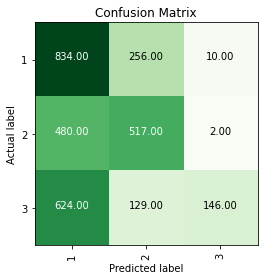

In [42]:
show_results(Y_pred, predictions)

### Creating Submission File

In [45]:
predictions_num = predictions

In [46]:
import zipfile
import os

with open('answer.txt',"w") as fp:
    fp.write("Uid,Sentiment\n")
    for i in range(len(predictions_num)):
        if predictions_num[i]==0:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",neutral")
            else:
                fp.write(all_test_tweets[i].uid+",neutral\n")
        elif predictions_num[i]==1:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",positive")
            else:
                fp.write(all_test_tweets[i].uid+",positive\n")                
        elif predictions_num[i]==2:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",negative")
            else:
                fp.write(all_test_tweets[i].uid+",negative\n")

class ZipUtilities:
    def toZip(self, file, filename):
        zip_file = zipfile.ZipFile(filename, 'w')
        if os.path.isfile(file):
            zip_file.write(file)
        else:
            self.addFolderToZip(zip_file, file)
        zip_file.close()

    def addFolderToZip(self, zip_file, folder): 
        for file in os.listdir(folder):
            full_path = os.path.join(folder, file)
            if os.path.isfile(full_path):
                print( 'File added: ' + str(full_path))
                zip_file.write(full_path)
            elif os.path.isdir(full_path):
                print( 'Entering folder: ' + str(full_path))
                self.addFolderToZip(zip_file, full_path)

utilities = ZipUtilities()
filename = 'answer.zip'
directory = 'answer.txt'
utilities.toZip(directory, filename)